## Studying the Ranks of a Random Graph and the Runtime Complexity
### Jeremy Kazimer
### Dane Taylor
### 8/8/2021

#### _Import Statements_

In [1]:
# Data structures
import numpy as np
import pandas as pds

# System and utility
import os, sys
import time
sys.path.append('utility')

from VNE_util import *
from graphs_util import *

# Plots and graphs
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter, NullFormatter

#### _Creating a Network_

We begin by creating a network with the parameters $N = 100$ and $p = 0.2$.  This can be modified to whatever you would like, but this is what we have decided on.

In [2]:
N = 100
M = 5*N

A = Erdos_Renyi_Gnm(N, M)

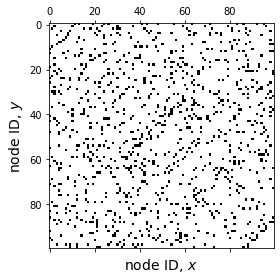

In [3]:
fig, ax = plt.subplots(1, 1)

ax.spy(A)
ax.set_ylabel('node ID, $y$', fontsize = 14)
ax.set_xlabel('node ID, $x$', fontsize = 14)

fig.tight_layout()

Now that we have the network, we can begin by ranking it.

#### _Ranking by Edges_

In [4]:
epsilons = [1]

In [5]:
Hs1, sorts1, ranks1 = edge_rankings(A, 1, epsilons[0])

We can compare the results of the actual perturbation to our approximation in terms of ranks to see how it fairs.  This is what the plot below demonstrates:

In [6]:
np.corrcoef(ranks1[0], ranks1[1])

array([[1.        , 0.99423777],
       [0.99423777, 1.        ]])

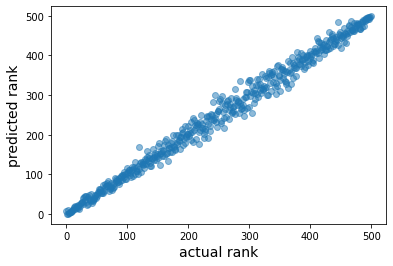

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.scatter(ranks1[0], ranks1[1], alpha = 0.5, label = r'$\epsilon = $' + str(epsilons[0]))

ax.set_ylabel('predicted rank', fontsize = 14)
ax.set_xlabel('actual rank', fontsize = 14);

We can also look at accuracy by defining some $l \in \mathbb{N}$ such that $l = 10$ means we compare accuracy for the top 10 ranks.

In [8]:
def accuracy(sorts, ranks, l):
    set_int = np.intersect1d(ranks[0][sorts[0][:l]], ranks[1][sorts[0][:l]])
    return len(set_int)/l

In [9]:
edges = get_edges(A)

ls = np.arange((edges.shape[0])) + 1
acc = np.ones_like(ls, dtype = float)

for l in ls:
    acc[l - 1] = accuracy(sorts1, ranks1, l)

Text(0.5, 0, 'actual rank')

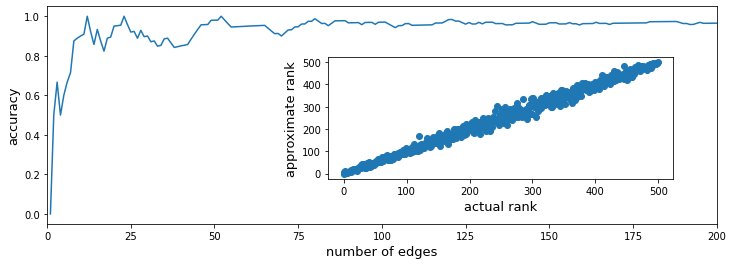

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (12, 4))

left, bottom, width, height = [0.45, 0.28, 0.4, 0.425]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.scatter(ranks1[0], ranks1[1])
ax1.plot(ls, acc)

ax1.set_ylabel('accuracy', fontsize = 13)
ax1.set_xlabel('number of edges', fontsize = 13)
ax1.set_xlim(0, 200)
ax2.set_ylabel('approximate rank', fontsize = 13)
ax2.set_xlabel('actual rank', fontsize = 13)

It is apparent that our approximation does well.  Since it's accurate, the real question remains about how long it takes to run, comparatively.  If it's not any faster or even slower than the actual method, then there is absolutely no reason to use our approximation.  We'll look at this next.

#### _Runtime Complexity_

For this portion, we will fix $\beta = 1$ and $\epsilon = 1$ to look at the time that it takes to complete edge removals for different network sizes.  In particular, we will fix the node degree $d$ to be $10$ so that this is a constant value.

In [11]:
beta = 1
epsilon = 1
d = 5

In [12]:
Ns = np.logspace(np.log10(2000), 4, 50).astype(int)
Ns

Ms = 5*Ns

In [18]:
true_ts = np.zeros((Ns.shape[0]))

for idx, N in enumerate(Ns):
    print('network size: {}'.format(N), '\r', end = '')

    A = Erdos_Renyi_Gnm(N, Ms[idx])

    edges = get_edges(A)[0].reshape(1, 2)

    t0 = time.time()

    for _, edge in enumerate(edges):
        # Index the edge
        i, j = edge

        # Temporarily remove the entry:
        A[i, j] = 0
        A[j, i] = 0

        # Calculate entropy.  Don't store, just observe runtime.
        # No need to subtract H0, that should be near O(1)
        B_entropy(A, beta).sum()

        # Restore edge
        A[i, j] = 1
        A[j, i] = 1

    true_ts[idx] = (time.time() - t0) * np.sum(A)/2

In [19]:
pert_ts = np.zeros((Ns.shape[0]))
Hs = []

for idx, N in enumerate(Ns):
    print('network size: {}'.format(N), '\r', end = '')

    A = Erdos_Renyi_Gnm(N, Ms[idx])
    A0 = A.copy()
    L0 = laplacian(A0)
    L = L0.copy()
    eigs, vecs = np.linalg.eigh(L0)

    edges = get_edges(A)

    f = np.exp(-beta*eigs)
    f /= f.sum()

    dhdf = f*(-np.log2(f) + 1/np.log(2))

    t0 = time.time()

    for _, edge in enumerate(edges):
        # Index the edge
        i, j = edge

        # Calculate entropy.  Don't store, just observe runtime.
        B_perturbation_1_edge(1, i, j, f, dhdf, vecs, epsilon, beta)


    pert_ts[idx] = time.time() - t0

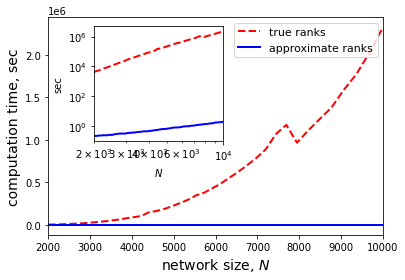

In [20]:
fig, axs = plt.subplots(1, 1)

# normal space plot
axs.plot(Ns, true_ts, label = 'true ranks', c = 'red', lw = 2, ls = '--')
axs.plot(Ns, pert_ts, label = 'approximate ranks', c = 'blue', lw = 2)

axs.legend(loc='upper right', fontsize = 11)

axs.set_xlim(Ns[0], Ns[-1])

axs.set_xlabel('network size, $N$', fontsize = 14)
axs.set_ylabel('computation time, sec', fontsize = 14)

#loglog plot

left, bottom, width, height = [0.23, 0.45, 0.3, 0.4]
axs2 = fig.add_axes([left, bottom, width, height])

axs2.loglog(Ns, true_ts, label = r'$dH_{true}$', c = 'red', lw = 2, ls = '--')
axs2.loglog(Ns, pert_ts, label = r'$dH_{pert}$', c = 'blue', lw = 2)


axs2.set_xlim(Ns[0], Ns[-1])

axs2.set_xlabel('$N$', fontsize = 10)
axs2.set_ylabel('sec', fontsize = 10);

Here, we can see that the true ranks take much longer to compute than that of the approximate ranks.  This means that our method is both highly accurate and more fast in comparison to the non-approximate method.  As such, this is usable in place of the non-approximate method! We can combine both graphs for an easy comparison, now.

In [21]:
save = False

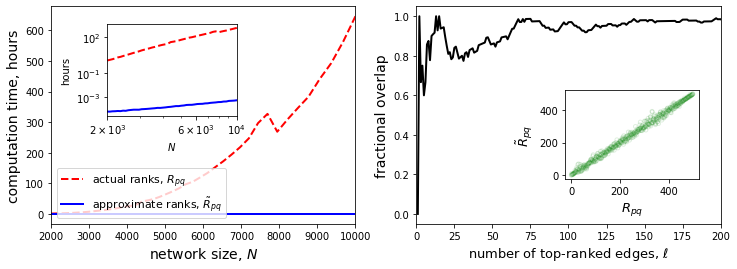

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

ax2, ax1 = axs

left, bottom, width, height = [0.72, 0.28, 0.155, 0.31]
ax3 = fig.add_axes([left, bottom, width, height])

ax3.scatter(ranks1[0], ranks1[1], alpha = 0.125, s = 15, marker = 'o', facecolors='none', edgecolors='green')
ax1.plot(ls, acc, lw = 2, c = 'k')

ax1.set_xlim(0, 200)
ax3.set_ylabel(r'$\tilde{R}_{pq}$', fontsize = 13)
ax3.set_xlabel('$R_{pq}$', fontsize = 13)


ax1.set_ylabel(r'fractional overlap', fontsize = 14)
ax1.set_xlabel('number of top-ranked edges, $\ell$', fontsize = 13)



ax2.plot(Ns, true_ts/(60*60), label = r'actual ranks, $R_{pq}$', c = 'red', lw = 2, ls = '--')
ax2.plot(Ns, pert_ts/(60*60), label = r'approximate ranks, $\tilde{R}_{pq}$', c = 'blue', lw = 2)

ax2.legend(loc='lower left', fontsize = 11)

ax2.set_xlim(Ns[0], Ns[-1])

ax2.set_xlabel('network size, $N$', fontsize = 14)
ax2.set_ylabel('computation time, hours', fontsize = 14)

#loglog plot

left, bottom, width, height = [0.19, 0.5, 0.15, 0.32]
ax4 = fig.add_axes([left, bottom, width, height])

ax4.plot(Ns, true_ts/(60*60), label = r'$dH_{true}$', c = 'red', lw = 2, ls = '--')
ax4.plot(Ns, pert_ts/(60*60), label = r'$dH_{pert}$', c = 'blue', lw = 2)
ax4.set_xscale('log')
ax4.set_yscale('log')

ax4.set_xticks([2e3, 6e3, 1e4])
ax4.set_yticks([10e1, 10e-2, 10e-4])
ax4.set_xlim(Ns[0], Ns[-1])


ax4.get_xaxis().set_minor_formatter(NullFormatter())


ax4.set_xlabel('$N$', fontsize = 10)
ax4.set_ylabel('hours', fontsize = 10);

if save == True:
    fig.savefig('complexity_and_accuracy.pdf')

In [23]:
np.polyfit(np.log(Ns), np.log(pert_ts), 1)[0]

array([  1.40329414, -12.34153156])

In [24]:
np.polyfit(np.log(Ns), np.log(true_ts), 1)[0]

array([  3.96220918, -21.57366877])

---